## Real time deployment of machine learning algorithms for predicting the magnetic flux rope structure in coronal mass ejections and Bz overview plots

This is a code adapted for real time Bz prediction from the Reiss et al. 2021 Space Weather paper, that we call *MLBz*.
https://agupubs.onlinelibrary.wiley.com/doi/10.1029/2021SW002859

This notebook is used for real time deployment.

Additionally in the beginning some general plots on Bz behavior are produced, which give a first hint on how to use the minimum Bz value predicted from *MLBz* for Dst forecasting.

### Update
last update 2024 September

For local development from section 2 onwards, run heliocats/data_update_web_hf.ipynb first to get the real time data

### Ideas

- deploy in real time for data files for STEREO-A and NOAA RTSW  under folder data_path:
"stereoa_beacon_gsm_last_35days_now.p" and "noaa_rtsw_last_35files_now.p"
- read in ML model trained with the notebooks mfrpred_real_bz (done), mfpred_real_btot (need to update)
- continous deployment, look at results during CMEs
- assess progression of results in real time as more of the CME is seen
- needs different trained model for each timestep, i.e. for different hours after sheath and MFR entry?
- add general Bz distribution plots here at the end


### Future
- forecast of the cumulative southward Bz during a geomagnetic storm?
- start at time of shock, and then decrease the error bars with time
- correlate with Dst

pattern recognition
https://agupubs.onlinelibrary.wiley.com/doi/10.1002/2016SW001589

bz after shocks
https://agupubs.onlinelibrary.wiley.com/doi/10.1029/2018SW002056

#### Authors: 
M.A. Reiss (1), C. Möstl (2), R.L. Bailey (3), and U. Amerstorfer (2), Emma Davies (2), Eva Weiler (2)

(1) NASA CCMC, 
(2) Austrian Space Weather Office, GeoSphere Austria
(3) Conrad Observatory, GeoSphere Austria


In [27]:
########### controls
print()
print('started mfrpred_deploy.py')


################

import time

#test execution times
t0all = time.time()


import os
import sys
import copy
import matplotlib.pyplot as plt
from matplotlib.dates import date2num, num2date
from matplotlib import cm
import numpy as np
import pickle
from scipy import stats
import scipy.io
import time
import datetime

# Visualisation
import sunpy.time
import seaborn as sns
import pandas as pd
from pandas.plotting import scatter_matrix
from sunpy.time import parse_time

from scipy.stats import linregress

# Machine learning
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, median_absolute_error, r2_score
from sklearn.feature_selection import SelectKBest, SelectPercentile, f_classif
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.linear_model import ElasticNet, HuberRegressor, Lars, LassoLars
from sklearn.linear_model import PassiveAggressiveRegressor, RANSACRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

# Don't print warnings
import warnings
warnings.filterwarnings('ignore')

os.system('jupyter nbconvert --to script mfrpred_deploy.ipynb')    

#get data paths
if sys.platform == 'linux': 
    
    from config_server import data_path
    from config_server import noaa_path
    from config_server import wind_path
    from config_server import stereoa_path
    from config_server import data_path_ml
    
if sys.platform =='darwin':  

    from config_local import data_path
    from config_local import noaa_path
    from config_local import wind_path
    from config_local import stereoa_path
    from config_local import data_path_ml


started mfrpred_deploy.py


[NbConvertApp] Converting notebook mfrpred_deploy.ipynb to script
[NbConvertApp] Writing 21135 bytes to mfrpred_deploy.py


# (1) General Bz overview plots

### flux ropes types diagram 
adapted from Rüdisser et al. 2024 ApJ - uncomment!
<!--  ![](illustrations/fr_types/Flux_Rope_Orientations.001.jpeg) -->

#### load OMNI data and HELIO4CAST ICMECAT

In [28]:
fileomni="omni_1963_now.p"
[o,ho]=pickle.load(open(data_path+fileomni, "rb" ) )  

[ic,header,parameters] = pickle.load(open('data/ICMECAT/HELIO4CAST_ICMECAT_v22_pandas.p', "rb" ))

print()
print('ICMECAT loaded')

# Spacecraft
isc = ic.loc[:,'sc_insitu'] 

# Shock arrival or density enhancement time
icme_start_time = ic.loc[:,'icme_start_time']
icme_start_time_num = date2num(np.array(icme_start_time))

# Start time of the magnetic obstacle (mo)
mo_start_time = ic.loc[:,'mo_start_time']
mo_start_time_num = date2num(np.array(mo_start_time))

# End time of the magnetic obstacle (mo)
mo_end_time = ic.loc[:,'mo_end_time']
mo_end_time_num = date2num(np.array(mo_end_time))

#get indices for each target
wini=np.where(ic.sc_insitu=='Wind')[0]
stai=np.where(ic.sc_insitu=='STEREO-A')[0]
stbi=np.where(ic.sc_insitu=='STEREO-B')[0]
pspi=np.where(ic.sc_insitu=='PSP')[0]
soloi=np.where(ic.sc_insitu=='SolarOrbiter')[0]
bepii=np.where(ic.sc_insitu=='BepiColombo')[0]
ulyi=np.where(ic.sc_insitu=='Ulysses')[0]
messi=np.where(ic.sc_insitu=='Messenger')[0]
vexi=np.where(ic.sc_insitu=='VEX')[0]
ic.keys()


ICMECAT loaded


Index(['icmecat_id', 'sc_insitu', 'icme_start_time', 'mo_start_time',
       'mo_end_time', 'mo_sc_heliodistance', 'mo_sc_long_heeq',
       'mo_sc_lat_heeq', 'icme_duration', 'icme_bmax', 'icme_bmean',
       'icme_bstd', 'icme_speed_mean', 'icme_speed_std', 'mo_duration',
       'mo_bmax', 'mo_bmean', 'mo_bstd', 'mo_bzmean', 'mo_bzmin', 'mo_bzstd',
       'mo_bymean', 'mo_bystd', 'mo_speed_mean', 'mo_speed_std',
       'mo_expansion_speed', 'mo_pdyn_mean', 'mo_pdyn_std', 'mo_density_mean',
       'mo_density_std', 'mo_temperature_mean', 'mo_temperature_std',
       'sheath_speed_mean', 'sheath_speed_std', 'sheath_density_mean',
       'sheath_density_std', 'sheath_pdyn_mean', 'sheath_pdyn_std'],
      dtype='object')

### plot for minimum Bz vs time



saved plots/icme_bz_time.png




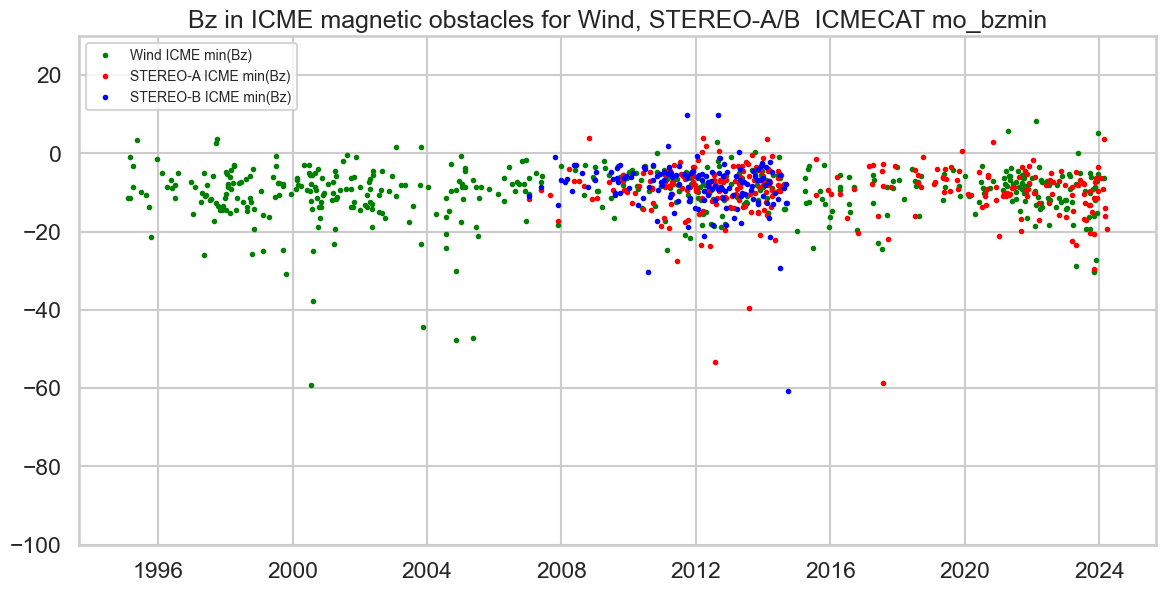

In [29]:
sns.set_context("talk")     
sns.set_style('whitegrid')

fig=plt.figure(figsize=(12,6),dpi=100)
ax1 = plt.subplot(111) 

ax1.plot(ic['icme_start_time'][wini],ic['mo_bzmin'][wini],'og',markersize=3,label='Wind ICME min(Bz)')
ax1.plot(ic['icme_start_time'][stai],ic['mo_bzmin'][stai],'or',markersize=3,label='STEREO-A ICME min(Bz)')
ax1.plot(ic['icme_start_time'][stbi],ic['mo_bzmin'][stbi],'ob',markersize=3,label='STEREO-B ICME min(Bz)')
ax1.set_ylim(-100,30)
plt.legend(fontsize=10,loc=2)
plt.tight_layout()
plt.title('Bz in ICME magnetic obstacles for Wind, STEREO-A/B  ICMECAT mo_bzmin')

plt.savefig('plots/icme_bz_time.png')


print()
print()
print('saved plots/icme_bz_time.png')
print()
print()

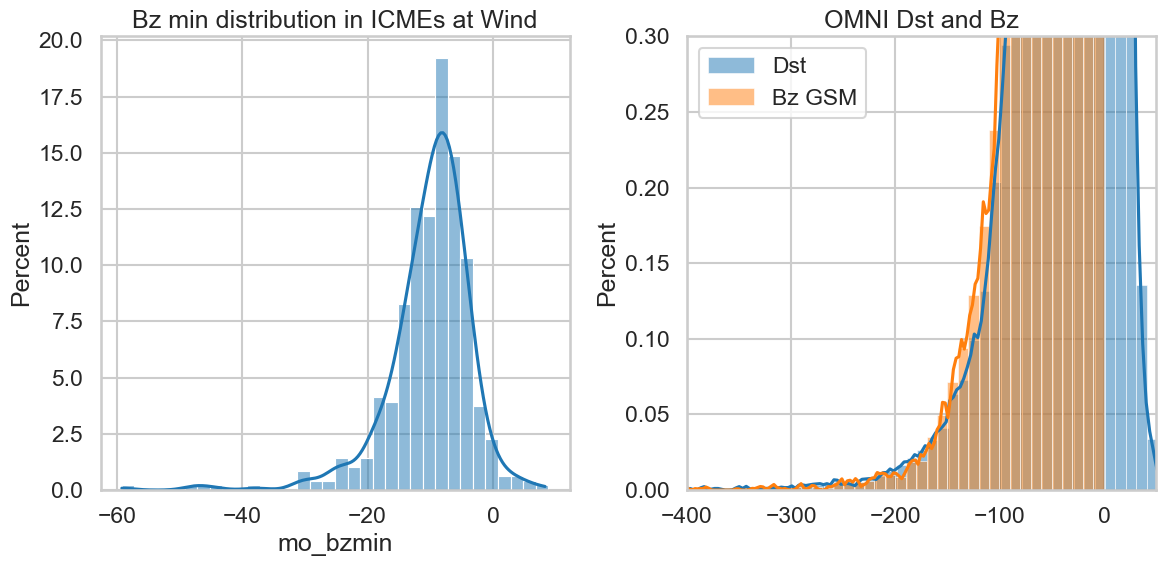

In [30]:
########### bz min distribution in ICMEs

fig=plt.figure(figsize=(12,6),dpi=100)
ax1 = plt.subplot(121) 


plt.title('Bz min distribution in ICMEs at Wind')
sns.histplot(ic['mo_bzmin'][wini],kde=True,binwidth=2, stat='percent')
#sns.distplot(ic['mo_bzmin'][stai])
#sns.distplot(ic['mo_bzmin'][stbi])

ax2 = plt.subplot(122) 


#determine the factor that matches the Dst Bz<0 distributions in GSM 

factor=9


#this is very handy for forecast guesses:
#-10 nT IMF has a potential -90 nT Dst

#however, above -150 the factor goes towards 10
#-100 nT has a potential -1000 nT Dst


#only Bz values <0 
obzlt0=o.bzgsm[np.where(o.bzgsm<0)[0]]


plt.title('OMNI Dst and Bz')
sns.histplot(o.dst,label='Dst',kde=True,binwidth=10, stat='percent')
sns.histplot(obzlt0*factor,label='Bz GSM',kde=True,binwidth=10,stat='percent')
plt.legend()
ax2.set_xlim(-400,50)
ax2.set_ylim(0,0.3)



plt.tight_layout()

In [31]:
###########
bzmin=ic['mo_bzmin'][wini]
ne=len(bzmin)

print('stats')
print()

print('How many ICMEs at Wind have Bz < 0 nT')
print(len(np.where(bzmin < 0)[0]),np.round(len(np.where(bzmin < 0)[0])/ne*100,1), '%')

print('How many ICMEs at Wind have Bz < -5 nT')
print(len(np.where(bzmin < -5)[0]),np.round(len(np.where(bzmin < -5)[0])/ne*100,1), '%')

print('How many ICMEs at Wind have Bz < -10 nT')
print(len(np.where(bzmin < -10)[0]),np.round(len(np.where(bzmin < -10)[0])/ne*100,1), '%')

print('How many ICMEs at Wind have Bz < -15 nT')
print(len(np.where(bzmin < -15)[0]),np.round(len(np.where(bzmin < -15)[0])/ne*100,1), '%')

print('How many ICMEs at Wind have Bz < -20 nT')
print(len(np.where(bzmin < -20)[0]),np.round(len(np.where(bzmin < -20)[0])/ne*100,1), '%')

print('How many ICMEs at Wind have Bz < -30 nT')
print(len(np.where(bzmin < -30)[0]),np.round(len(np.where(bzmin < -30)[0])/ne*100,1), '%')

print('How many ICMEs at Wind have Bz < -40 nT')
print(len(np.where(bzmin < -40)[0]),np.round(len(np.where(bzmin < -40)[0])/ne*100,1), '%')

print('How many ICMEs at Wind have Bz < -50 nT')
print(len(np.where(bzmin < -50)[0]),np.round(len(np.where(bzmin < -50)[0])/ne*100,1), '%')

      

stats

How many ICMEs at Wind have Bz < 0 nT
472 97.5 %
How many ICMEs at Wind have Bz < -5 nT
404 83.5 %
How many ICMEs at Wind have Bz < -10 nT
200 41.3 %
How many ICMEs at Wind have Bz < -15 nT
75 15.5 %
How many ICMEs at Wind have Bz < -20 nT
28 5.8 %
How many ICMEs at Wind have Bz < -30 nT
8 1.7 %
How many ICMEs at Wind have Bz < -40 nT
4 0.8 %
How many ICMEs at Wind have Bz < -50 nT
1 0.2 %


### Duration of ICMEs

mean ICME_duration at Wind [hours] 29.61 +/- 15.13
mean sheath_duration at Wind [hours] 6.85 +/- 6.87
mean MO_duration at Wind [hours] 22.76 +/- 12.49
saved  plots/icme_mo_duration.png



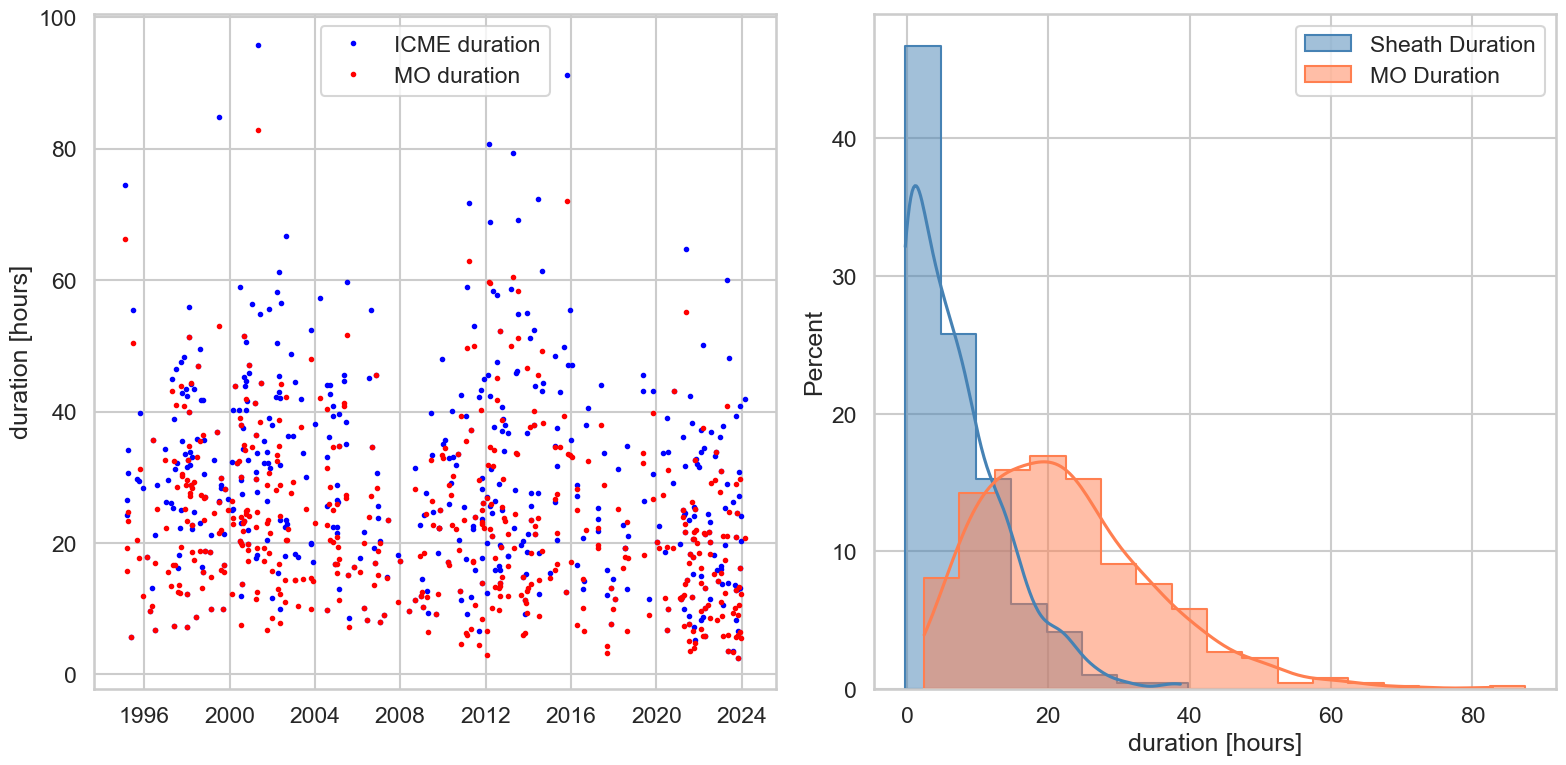

In [32]:
sns.set_context("talk")     
sns.set_style('whitegrid')

fig=plt.figure(figsize=(16,8),dpi=100)
ax1 = plt.subplot(121) 

ax1.plot(ic['icme_start_time'][wini],ic['icme_duration'][wini],'ob',markersize=3,label='ICME duration')
ax1.plot(ic['icme_start_time'][wini],ic['mo_duration'][wini],'or',markersize=3,label='MO duration')
plt.legend()
ax1.set_ylabel('duration [hours]')

ax2 = plt.subplot(122) 
sns.histplot(ic.loc[wini,'icme_duration']-ic.loc[wini,'mo_duration'],label='Sheath Duration',color='steelblue',kde=True,stat='percent', element='step',binwidth = 5)
sns.histplot(ic.loc[wini,'mo_duration'],label='MO Duration',color='coral',kde=True,stat='percent', element='step',binwidth = 5)
plt.legend()
ax2.set_xlabel('duration [hours]')


print('mean ICME_duration at Wind [hours]',np.round(np.nanmean(ic['icme_duration'][wini]),2),'+/-',np.round(np.nanstd(ic['icme_duration'][wini]),2))

print('mean sheath_duration at Wind [hours]',np.round(np.nanmean(ic['icme_duration'][wini]-ic['mo_duration'][wini]),2), '+/-',np.round(np.nanstd(ic['icme_duration'][wini]-ic['mo_duration'][wini]),2))

print('mean MO_duration at Wind [hours]',np.round(np.nanmean(ic['mo_duration'][wini]),2),'+/-',np.round(np.nanstd(ic['mo_duration'][wini]),2))

plt.tight_layout()

plt.savefig('plots/icme_mo_duration.png')

savefile='plots/icme_mo_duration.png'
plt.savefig(savefile)

#savefile='plots/icme_mo_duration.pdf'
#plt.savefig(savefile)


print('saved ',savefile)
print()



### Bz vs Dst for Wind ICMEs

Text(0, 0.5, 'MO Bzmin Wind [nT]')

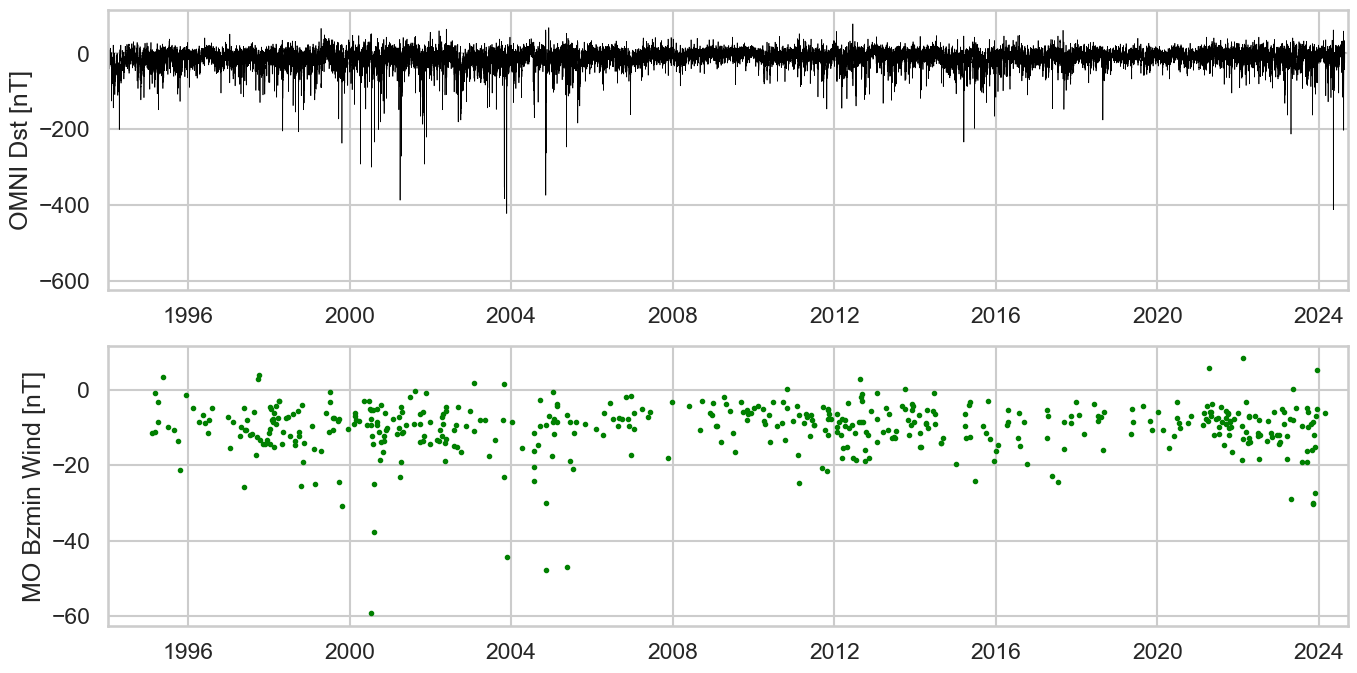

In [33]:
start=datetime.datetime(1994,1,1)
end=datetime.datetime.utcnow() 

sns.set_context("talk")     
sns.set_style('whitegrid')

fig=plt.figure(figsize=(16,8),dpi=100)

plt.title('Dst and MO Bz min')
ax1 = plt.subplot(211) 
ax1.plot(o.time,o.dst,'-k',lw=0.5)
ax1.set_xlim(start, end)
ax1.set_ylabel('OMNI Dst [nT]')

ax2 = plt.subplot(212) 
ax2.plot(ic['icme_start_time'][wini],ic['mo_bzmin'][wini],'og',markersize=3,label='Wind ICME min(Bz)')
ax2.set_xlim(start, end)
ax2.set_ylabel('MO Bzmin Wind [nT]')

### plot min Bz in ICMEs vs. Dst from OMNI

In [34]:
#min Bz from ICMECAT

bz_min=np.array(ic['mo_bzmin'][wini])
bz_mean=np.array(ic['mo_bzmean'][wini])
bz_std=np.array(ic['mo_bzstd'][wini])

#number of events
ne=len(bz_min)

print('number of Wind events',ne)

#start and end times of MO

win_start=np.array(ic['mo_start_time'][wini])
win_end=np.array(ic['mo_end_time'][wini])

#dst index

#o.time
#o.dst

#win_start

#get minimum Dst for each Wind ICMECAT event
#define array
dst_min=np.zeros(ne)
dst_std=np.zeros(ne)
dst_max=np.zeros(ne)
dst_mean=np.zeros(ne)



print(ne)
#dstmin
#bzmin

make_indices=0

if make_indices > 0: 
    
    for i in np.arange(ne):
        #get the interval of the Wind MO in the OMNI data
        ostart=np.where(o.time > win_start[i])[0][0]
        #-1 so the omni data end time is before the mo_end_time
        oend=np.where(o.time > win_end[i])[0][0]-1
        #print(o.time[oend])
        #print(win_end[i])        
        #print()
        dst_min[i]=np.nanmin(o.dst[ostart:oend])
        dst_std[i]=np.nanstd(o.dst[ostart:oend])
        dst_max[i]=np.nanmax(o.dst[ostart:oend])
        dst_mean[i]=np.nanmean(o.dst[ostart:oend])        
        
        #print(dstmin[i], dstmin_std[i])
    
    pickle.dump([dst_min,dst_std,dst_max,dst_mean], open('data/dstmin.p', "wb"))

    
#load pickle
[dst_min,dst_std,dst_max,dst_mean] = pickle.load(open('data/dstmin.p', "rb"))

number of Wind events 484
484


Fitted parameters: [ -0.06036381   3.26256422 -14.87722044]
0.6693887720778435 3.3520497486854914e-64
0.2712796262617135 3.320915514892053
5.366381918923674 -2.57819204325083
Slope for linear fit to go from Bz to Dst min in a magnetic obstacle is 5.37
note Bz in HEEQ in ICMECAT?
saved  plots/bz_min_dst_min.png



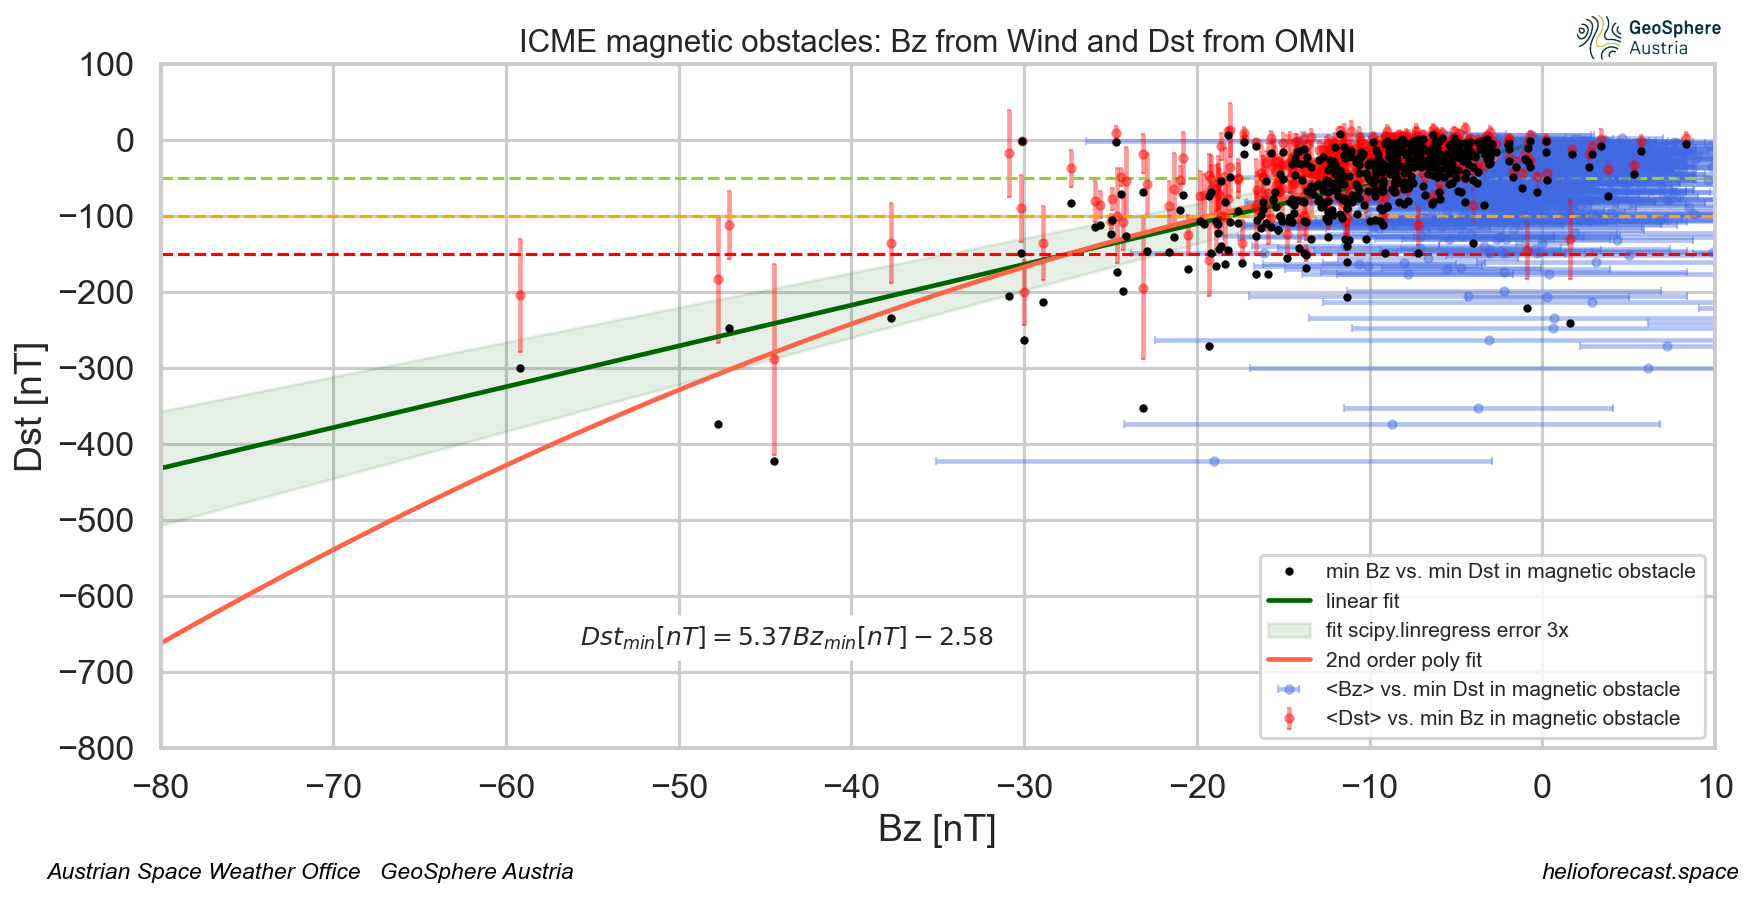

In [35]:
fig=plt.figure(figsize=(12,6),dpi=150)
ax1 = plt.subplot(111) 

ax1.errorbar(bz_mean, dst_min, xerr=bz_std, color='royalblue',fmt='o', ecolor='royalblue', markersize=4,capsize=2,alpha=0.4, label='<Bz> vs. min Dst in magnetic obstacle')
ax1.errorbar(bz_min, dst_mean, yerr=dst_std, color='red',fmt='o', ecolor='red', markersize=4,capsize=1,alpha=0.4, label='<Dst> vs. min Bz in magnetic obstacle')
ax1.plot(bz_min,dst_min,'ok',markersize=3, label='min Bz vs. min Dst in magnetic obstacle',zorder=3)

#sns.kdeplot(x=bz_min, y=dst_min, cmap="Reds", fill=True)

#ax1.plot(bzmin,dst_mean,'or',markersize=3,alpha=0.5)
#ax1.plot(bzmin,dst_mean,'or',markersize=2,alpha=0.5)

ax1.set_xlim(-80,10)
ax1.set_ylim(-800,100)

plt.title('ICME magnetic obstacles: Bz from Wind and Dst from OMNI',fontsize=15)

ax1.set_xlabel('Bz [nT]')
ax1.set_ylabel('Dst [nT]')



############# Perform the polynomial fit
from scipy.optimize import curve_fit



x_fit=np.linspace(-100,0,101)

# Define the polynomial function
def poly_func(x, a, b, c):
    return a * x**2 + b * x + c

res2, _ = curve_fit(poly_func, bz_min, dst_min)

y_fit_poly2 = poly_func(x_fit, *res2)

print(f"Fitted parameters: {res2}")


########################## Perform linear regression
res = linregress(bz_min, dst_min)

#slope, intercept, rvalue, pvalue, stderr,intercept_stderr 
print(res.rvalue,res.pvalue)
print(res.stderr,res.intercept_stderr)
print(res.slope, res.intercept)

y_fit = res.slope * x_fit + res.intercept

y_fit1 = (res.slope + res.stderr*3) * x_fit + res.intercept-res.intercept_stderr*3
y_fit2 = (res.slope-res.stderr*3) * x_fit + res.intercept+res.intercept_stderr*3


ax1.plot(x_fit,y_fit,color='darkgreen',label='linear fit')
ax1.plot(x_fit,y_fit1,color='darkgreen',linestyle='--',alpha=0.0)
ax1.plot(x_fit,y_fit2,color='darkgreen',linestyle='--',alpha=0.0)
plt.fill_between(x_fit, y_fit1, y_fit2, color='darkgreen', alpha=0.1, label='fit scipy.linregress error 3x')



ax1.plot(x_fit,y_fit_poly2,color='tomato',label='2nd order poly fit')



formulastring='$Dst_{min} [nT]='+str(np.round(res.slope,2))+'  Bz_{min} [nT]'+str(np.round(res.intercept,2))+'}$'
ax1.annotate(formulastring,xy=(0.403,0.15),xycoords='axes fraction',fontsize=12,ha='center',bbox=dict(boxstyle='round', facecolor='white'))
ax1.legend(fontsize=10,loc=4)


ax1.axhline(y=-50, color='yellowgreen', linestyle='--',label='moderate',lw=1.5)
ax1.axhline(y=-100, color='orange', linestyle='--',label='intense',lw=1.5)
ax1.axhline(y=-150, color='red', linestyle='--',label='',lw=1.5)
#ax1.axhline(y=-200, color='d', linestyle='--',label='')


logo = plt.imread('logo/GSA_Basislogo_Positiv_RGB_XXS.png')
newax = fig.add_axes([0.89,0.89,0.08,0.08], anchor='NE', zorder=1)
newax.imshow(logo)
newax.axis('off')


plt.tight_layout()

print('Slope for linear fit to go from Bz to Dst min in a magnetic obstacle is', np.round(res.slope,2))
print('note Bz in HEEQ in ICMECAT?')

fsize=15
plt.figtext(0.04,0.01,'Austrian Space Weather Office   GeoSphere Austria', color='black', ha='left',fontsize=fsize-4, style='italic')
plt.figtext(0.98,0.01,'helioforecast.space', color='black', ha='right',fontsize=fsize-4, style='italic')


savefile='plots/bz_min_dst_min.png'
plt.savefig(savefile)
print('saved ',savefile)
print()




In [36]:
# make the same for product V x Bz, or for newell coupling
# predict Bz and V, make Newell coupling, compare to observed Newell coupling

### plot min Bz in ICMEs vs. sheath speed

928
saved  plots/vs_mean_bz_min.png



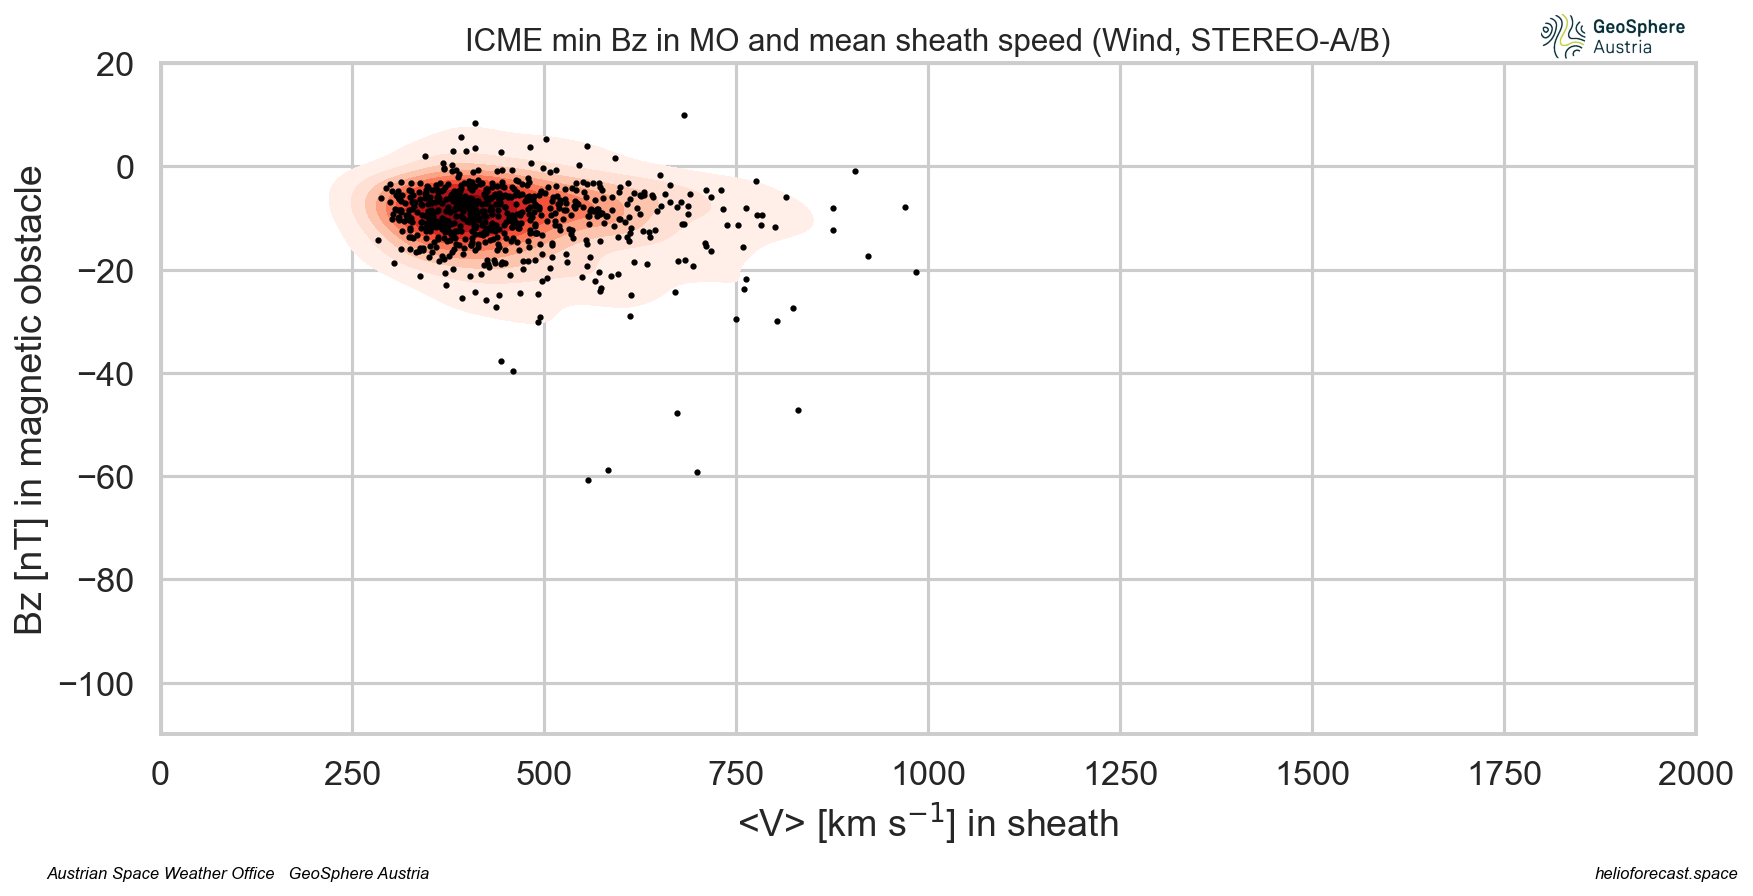

In [37]:
# für forecast ein plot für uns
# b in situ vs v in situ, aus eleco v -> max b und max bz vorhersagen, sozusagen den bottom floor

#bz_mean=np.array(ic['mo_bzmean'][wini])
#bz_std=np.array(ic['mo_bzstd'][wini])
#b_max=np.array(ic['mo_bmax'][wini])


bz_minw=np.array(ic['mo_bzmin'][wini])
bz_mina=np.array(ic['mo_bzmin'][stai])
bz_minb=np.array(ic['mo_bzmin'][stbi])

vs_meanw=np.array(ic['sheath_speed_mean'][wini])
vs_meana=np.array(ic['sheath_speed_mean'][stai])
vs_meanb=np.array(ic['sheath_speed_mean'][stbi])


#combine to single
bz=np.hstack([bz_minw,bz_mina,bz_minb])
vs=np.hstack([vs_meanw,vs_meana,vs_meanb])


fig=plt.figure(figsize=(12,6),dpi=150)
ax1 = plt.subplot(111) 

#ax1.errorbar(bz_mean, dst_min, xerr=bz_std, color='royalblue',fmt='o', ecolor='royalblue', markersize=4,capsize=2,alpha=0.4, label='<Bz> vs. min Dst in magnetic obstacle')
#ax1.errorbar(bz_min, dst_mean, yerr=dst_std, color='red',fmt='o', ecolor='red', markersize=4,capsize=1,alpha=0.4, label='<Dst> vs. min Bz in magnetic obstacle')

print(len(vs))

ax1.plot(vs,bz,'ok',markersize=2, label='mean V sheath vs. min Bz in magnetic obstacle',zorder=3)

#ax1.plot(vs_meanw,bz_minw,'or',markersize=2, label='mean V sheath vs. min Bz in magnetic obstacle',zorder=3)
#ax1.plot(vs_mean,b_max,'ok',markersize=3, label='mean V sheath vs. min Bz in magnetic obstacle',zorder=3)

sns.kdeplot(x=vs, y=bz, cmap="Reds", fill=True)

#ax1.plot(bzmin,dst_mean,'or',markersize=3,alpha=0.5)
#ax1.plot(bzmin,dst_mean,'or',markersize=2,alpha=0.5)

ax1.set_xlim(0,2000)
ax1.set_ylim(-110,20)


plt.title('ICME min Bz in MO and mean sheath speed (Wind, STEREO-A/B)',fontsize=15)

fsize=12


logo = plt.imread('logo/GSA_Basislogo_Positiv_RGB_XXS.png')
newax = fig.add_axes([0.87,0.89,0.08,0.08], anchor='NE', zorder=1)
newax.imshow(logo)
newax.axis('off')

     
plt.figtext(0.04,0.01,'Austrian Space Weather Office   GeoSphere Austria', color='black', ha='left',fontsize=fsize-4, style='italic')
plt.figtext(0.98,0.01,'helioforecast.space', color='black', ha='right',fontsize=fsize-4, style='italic')

ax1.set_xlabel('<V> [km s$^{-1}$] in sheath')
ax1.set_ylabel('Bz [nT] in magnetic obstacle')

plt.tight_layout()

savefile='plots/vs_mean_bz_min.png'
plt.savefig(savefile)
print('saved ',savefile)
print()


# (2) Construct a minimal Bz model


In [185]:
#only based on ICME statistics above


# (3) ML model application
from Reiss et al. 2021 Space Weather

### load real time data

In [186]:
filenoaa='noaa_rtsw_last_35files_now.p'
[noaa,hnoaa]=pickle.load(open(data_path+filenoaa, "rb" ) ) 

file_sta_beacon_gsm='stereoa_beacon_gsm_last_35days_now.p'  
[sta,hsta]=pickle.load(open(data_path+file_sta_beacon_gsm, "rb" ) )  

print('real time NOAA RTSW and STEREO-A data loaded')

#cutout last 10 days
start=datetime.datetime.utcnow() - datetime.timedelta(days=5)
end=datetime.datetime.utcnow() 

ind=np.where(noaa.time > start)[0][0]
noaa=noaa[ind:]

ind2=np.where(sta.time > start)[0][0]
sta=sta[ind2:]

real time NOAA RTSW and STEREO-A data loaded


(19974.592693934075, 19979.592693934283)

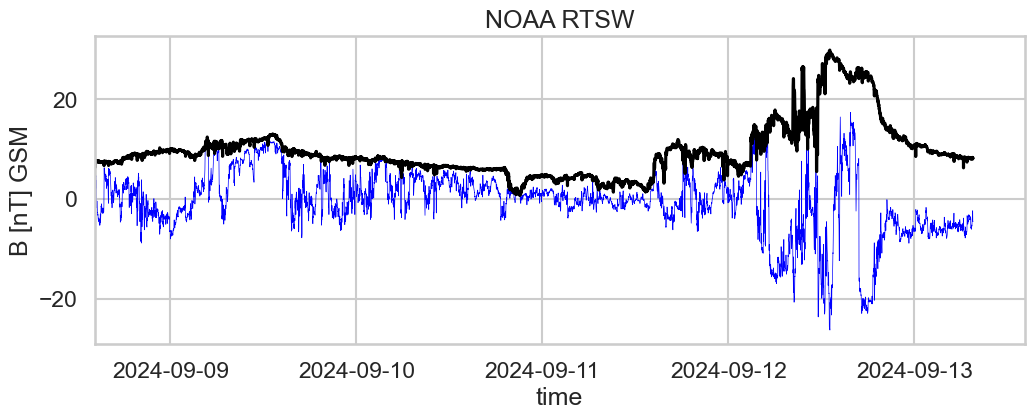

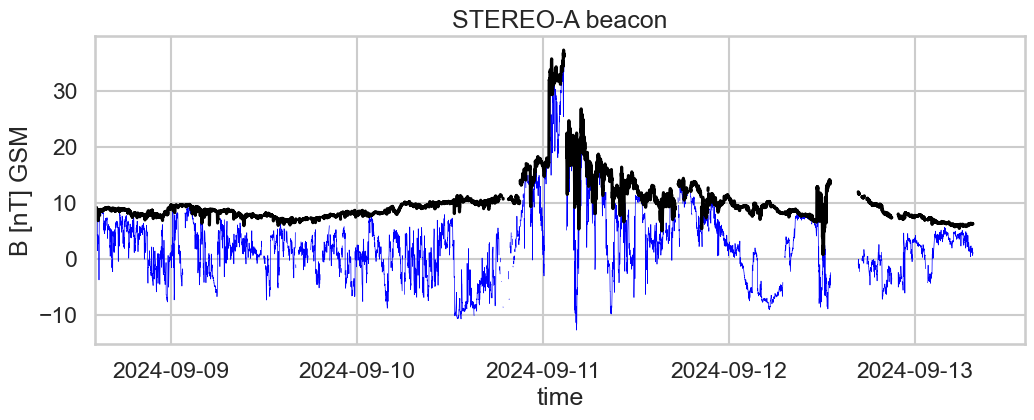

In [11]:

sns.set_context("talk")     
sns.set_style('whitegrid')

###plot NOAA
plt.figure(1,figsize=(12, 4),dpi=100)
plt.plot(noaa.time,noaa.bz, '-b',lw=0.5)
plt.plot(noaa.time,noaa.bt,'-k')

plt.title("NOAA RTSW")  # Adding a title
plt.xlabel("time")  # Adding X axis label
plt.ylabel("B [nT] GSM")  # Adding Y axis label
plt.grid(True)  # Adding a grid

plt.xlim(start, end)

#plot STEREO-A

plt.figure(2,figsize=(12, 4),dpi=100)
plt.plot(sta.time,sta.bz, '-b',lw=0.5)
plt.plot(sta.time,sta.bt,'-k')

plt.title("STEREO-A beacon")  # Adding a title
plt.xlabel("time")  # Adding X axis label
plt.ylabel("B [nT] GSM")  # Adding Y axis label
plt.grid(True)  # Adding a grid

plt.xlim(start, end)


(19978.759363852198, 19979.592697185693)

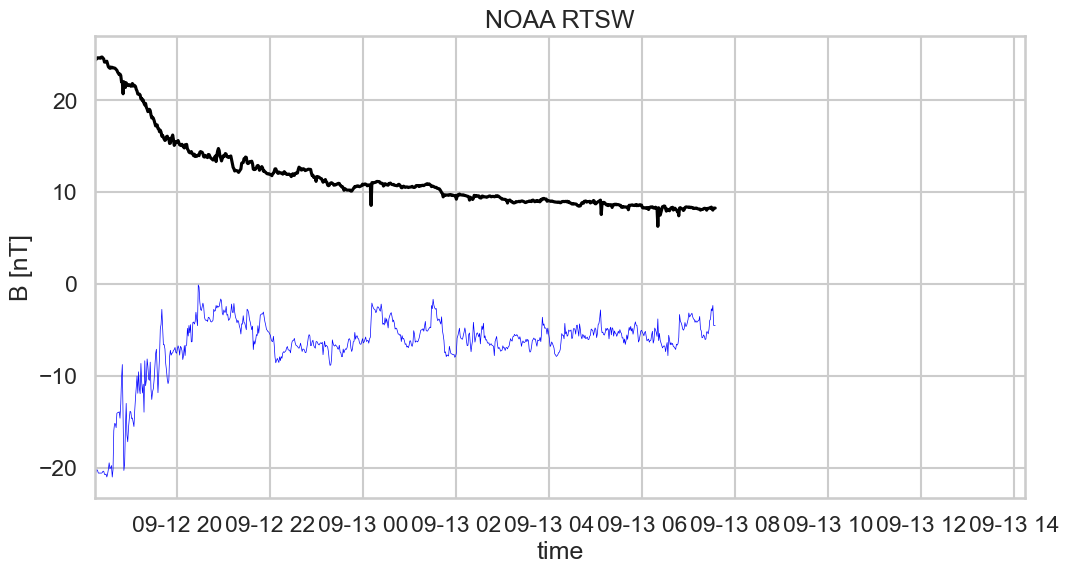

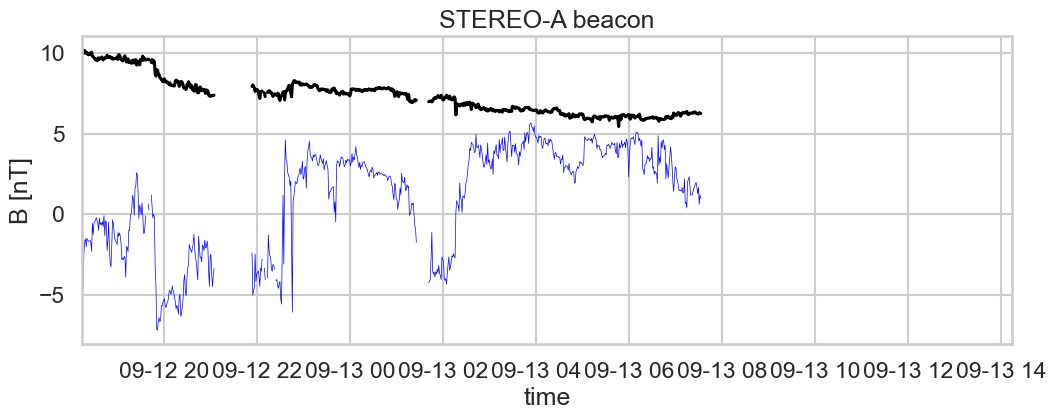

In [12]:

sns.set_context("talk")     
sns.set_style('whitegrid')

fig=plt.figure(figsize=(12,6),dpi=100)
#ax1 = plt.subplot(111) 


#cutout last 10 hours, e.g. sheath is over and flux rope starts
start=datetime.datetime.utcnow() - datetime.timedelta(hours=20)
end=datetime.datetime.utcnow() 

ind=np.where(noaa.time > start)[0][0]
noaa_cut=noaa[ind:]

ind2=np.where(sta.time > start)[0][0]
sta_cut=sta[ind2:]

###plot NOAA
plt.figure(1,figsize=(12, 4))
plt.plot(noaa_cut.time,noaa_cut.bz, '-b',lw=0.5)
plt.plot(noaa_cut.time,noaa_cut.bt,'-k')

plt.title("NOAA RTSW")  # Adding a title
plt.xlabel("time")  # Adding X axis label
plt.ylabel("B [nT]")  # Adding Y axis label
plt.grid(True)  # Adding a grid

plt.xlim(start, end)

#plot STEREO-A

plt.figure(2,figsize=(12, 4))
plt.plot(sta_cut.time,sta_cut.bz, '-b',lw=0.5)
plt.plot(sta_cut.time,sta_cut.bt,'-k')

plt.title("STEREO-A beacon")  # Adding a title
plt.xlabel("time")  # Adding X axis label
plt.ylabel("B [nT]")  # Adding Y axis label
plt.grid(True)  # Adding a grid

plt.xlim(start, end)



## (3.1) Reiss+ 2021 MLBz model

In [13]:

#what the model numbers mean
#model1 = models['lr'] 
#model2 = models['rfr'] 
#model3 = models['gbr'] 

feature_hours=10
[model1,model2,model3]=pickle.load(open('trained_models/bz_'+str(feature_hours)+'h_model.p','rb'))


print()
print('ML model loaded')

#model1.predict()
model2


#y_pred1 = model1.predict(X_test)

#y_pred1 sind die Bz predictions




ML model loaded


RandomForestRegressor(max_depth=5, min_samples_split=4, n_estimators=300)

### Apply MLBz model


In [14]:
## how to apply, first calculate features from current data? and then put into model

#feature space - map to model, get output

print()
print('ML model to be run on real time data')



ML model to be run on real time data


### Make output data files and plots

In [15]:
print()
print('results')
print()


results



## 3.2 Automatic flux rope type detection

In [16]:
t1all = time.time()

print(' ')
print('------------------')
print('Runtime for full high frequency data update:', np.round((t1all-t0all)/60,2), 'minutes')
print('------------------')

 
------------------
Runtime for full high frequency data update: 0.12 minutes
------------------
